In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.sampler import Sampler
import torch.optim as optim
import sys
sys.path.append('../')

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, collate_fn, get_data
from visualize import visualize
from model import fasterrcnn_resnet201_fpn, FastRCNNPredictor
from engine import evaluate
import utils

In [2]:
from train_lbp import get_train_test_list

In [3]:
import easydict 
args = easydict.EasyDict({ "batch_size": 2, 
                          "epochs": 50, 
                          "data": 0, 
                          'lr':0.1,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':5,
                          'workers':2})

In [4]:
df = pd.read_csv('../../data/df.csv')
df.head()
#df.insert(0, 'ID', range(0, len(df)))
#df.to_csv('../../data/df.csv', index=None)

,ID,file_name,task,bbox,xmin,ymin,w,h,label,occluded,des,cell_type
0,0,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[56, 35, 1980, 1985]",56,35,1980,1985,판독불가,0,NaN,NaN
1,1,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[56, 30, 1912, 1937]",56,30,1912,1937,판독불가,0,NaN,NaN
2,2,patch_images/2021.01.12/LBC305-20210108(1)/LBC...,[ASCUS] LBC305,"[21, 12, 2010, 2027]",21,12,2010,2027,판독불가,0,NaN,NaN
3,3,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1349, 420, 100, 113]",1349,420,100,113,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...
4,4,patch_images/2021.01.06/LBC37-20210102(1)/LBC3...,[ASCUS] LBC37,"[1575, 720, 163, 213]",1575,720,163,213,ASC-US,0,NaN,Atypical squamous cells of undetermined signif...


In [5]:
# Data loading code
data_dir = '../../data/df.csv'
train_list, test_list = get_train_test_list(data_dir)
train_dataset = LbpDataset(train_list, transform=train_transforms)
test_dataset = LbpDataset(test_list, transform=val_transforms)  

total 4019 train 3014 test 1005
3014
1005


In [6]:
# test_sampler = torch.utils.data.SequentialSampler(test_dataset)
# data_loader_test = torch.utils.data.DataLoader(
#     test_dataset, batch_size=args.batch_size,
#     sampler=test_sampler, num_workers=args.workers,
#     collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size,
    sampler=None,shuffle=True, num_workers=args.workers,
    collate_fn=utils.collate_fn)

In [7]:
num_classes = 2
model = fasterrcnn_resnet201_fpn(pretrained=False, min_size=2048, max_size=2048)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# model.to(device)

load customized pretrained backbone model


In [8]:
saved_model = '../trained_models/lbp_trained/model_119.pth'
device = torch.device('cpu')
state = torch.load(saved_model, map_location=device)
state_dict = state['model']
model.load_state_dict(state_dict)
model.eval()
print('load is done')

load is done


In [9]:
device = torch.device('cuda:5')
model.to(device)
print('model uploaded to gpu')

model uploaded to gpu


In [10]:
# evaluate(model, data_loader_test, device=device)

In [11]:
#images, targets = next(iter(test_dataset))
#print(images.shape)

torch.Size([3, 2048, 2048])


In [119]:
images, targets = next(iter(data_loader_test))
images = list(img.to(device) for img in images)
with torch.no_grad():
    outputs = model(images)
    outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
    
images = [image.to('cpu') for image in images]
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]    


patch_images/2021.01.06/LBC26-20210102(1)/LBC26-20210102(1)_1299.png
tensor([0.9878, 0.9826])
(2048, 2048, 3)


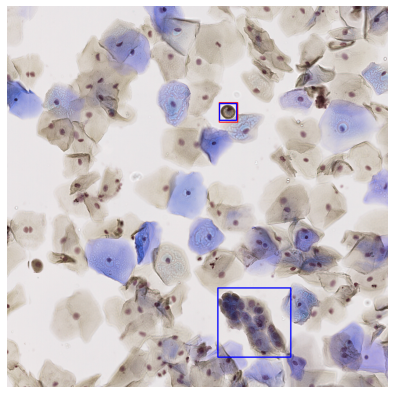

In [120]:
IMAGE_NUM = 0
image = images[IMAGE_NUM].numpy()
image = np.transpose(image, (1, 2, 0))
img_id = targets[IMAGE_NUM]['image_id'][0][0].numpy()
img_path = df[df['ID']==img_id].file_name.values[0]
print(img_path)
ground_boxes = targets[IMAGE_NUM]['boxes']
out_boxes = outputs[IMAGE_NUM]['boxes']
out_scores = outputs[IMAGE_NUM]['scores']
print(out_scores)

pred_boxes = []
for b, s in zip(out_boxes, out_scores) :
    if s > 0.5 :
        pred_boxes.append(b.numpy())

        
import cv2
abs_path = '/home/NAS/nas4/project_scl/'
image = cv2.imread(abs_path + img_path)
visualize(image, ground_boxes, pred_boxes)        

patch_images/2021.01.12/LBC311-20210108(1)/LBC311-20210108(1)_644.png
tensor([0.7481])
(2048, 2048, 3)


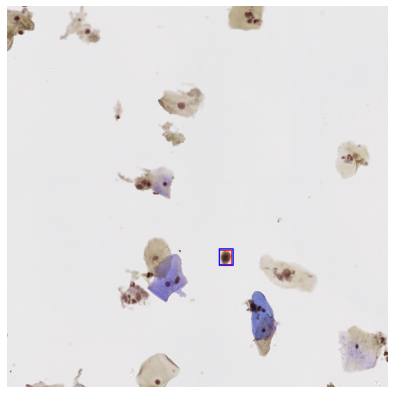

In [121]:
IMAGE_NUM = 1
image = images[IMAGE_NUM].numpy()
image = np.transpose(image, (1, 2, 0))
img_id = targets[IMAGE_NUM]['image_id'][0][0].numpy()
img_path = df[df['ID']==img_id].file_name.values[0]
print(img_path)
ground_boxes = targets[IMAGE_NUM]['boxes']
out_boxes = outputs[IMAGE_NUM]['boxes']
out_scores = outputs[IMAGE_NUM]['scores']
print(out_scores)

pred_boxes = []
for b, s in zip(out_boxes, out_scores) :
    if s > 0.5 :
        pred_boxes.append(b.numpy())

        
import cv2
abs_path = '/home/NAS/nas4/project_scl/'
image = cv2.imread(abs_path + img_path)
visualize(image, ground_boxes, pred_boxes)        

In [54]:
#visualize(image, ground_boxes)
#visualize(image, pred_boxes)